# Plot fig 1 box 7.2

Original code and data provided by Matt Palmer, post-edit by Chris Smith

Theme Song: Fix The Sky A Little<br>
Artist: 65daysofstatic<br>
Album: The Fall of Math<br>
Released: 2004

In [1]:
import pickle
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import string
from ar6.constants import NINETY_TO_ONESIGMA

In [2]:
def compute_energy(yrs, series, refyr=1971.):
    """
    This function converts radiative forcing timeseries in W m-2 to an equivalent energy
    change in Earth system in Zeta Joules (1e21 J).

    Inputs:
    yrs = input array of years
    series = input timeseries of (effective) radiative forcing
    refyr  = the reference year that energy changes are computed relative to

    Outputs:
    Jyrs = subset of years from refyr onwards
    Jseries = subset of series expressed in Zeta Joules
    """
    # surface area x seconds / zeta factor
    WtoZJ = (5.1e14 * 31557600) / 1e21  # Conversion factor Watts per square metre to Zeta Joules
    refi = np.where(yrs >= refyr)
    Jyrs = yrs[refi]
    Jseries = np.cumsum(series[refi]) * WtoZJ
    Jseries -= Jseries[0]  # Make sure that series is zero in 1971.
    return Jyrs, Jseries


def read_ERF_2_Joules(datadir='../data_output/',
                  filename='AR6_ERF_1750-2019.csv', skip=1, refyr1=1850., refyr2=1900.):
    """
    This function reads in the ERF component timeseries and integrates into energy change in ZJ
    returning a dictionary. 
    """
    f = open(datadir + filename, "r")
    lines = f.readlines()
    header = lines[skip-1].strip('\n')
    keys = header.split(',')
    f.close()
    ncols = len(lines[-1].split(','))  # Get number of columns from the last line..
    nrows = len(lines) - skip  # Get number of data lines in text file
    data = np.zeros([nrows, ncols])  # Convention of rows then columns for Numpy arrays (?)
    for jj in range(nrows):
        for ii in range(ncols):
            data[jj, ii] = float(lines[jj + skip].split(',')[ii])
    data_dict = dict.fromkeys(keys)
    for kk, key in enumerate(keys):
        data_dict[key] = data[:, kk]
    
    # Reference period for anomalising ERF
    yrs = data_dict['year'] # Extract array of years from data
    index = np.where((yrs >= refyr1) & (yrs <= refyr2))[0]
    
    # Delete the years from the dictionary for now, to save any confusion:
    del data_dict['year']
        
    data_dictJ = data_dict.copy() # Copy the dictionary for version in Joules
    
    # Loop over each key, apply 1850-1900 reference period and convert to joules
    for key in data_dict.keys():
        series = data_dict[key]
        series -= series[index].mean()
        Jyrs, Jseries = compute_energy(yrs, series)
        data_dictJ[key] = Jseries
    
    data_dictJ['yrs'] = Jyrs
    return data_dictJ


def plot_heating_rates(rates=[0.0, 0.25, 0.5, 0.75, 1.0, 1.5, 2.0],
                      fyr=1971., lyr=2018., ymax=1400., invert=False,
                       color='grey', linewidth=0.5, linestyle=':'):
    '''
    Function to plot heating rates expressed in W m-2 as lines in Zetta Joules
    Inputs:
     - rates = list of heating rates in W m-2
     - fyr, lyr = the first and last year to plot
     - ymax = the maximum value on the y-axis
     - invert = keyword for inverted values
    '''
    # To express W m-2 in Zetta Joules simply integrate over time and area then divide by 1e21 (Zetta)
    period = lyr-fyr
    yrsecs = 365.25*60*60*24
    area = 5.1e14
    zetta = 1e21
    
    if invert == True:
        rates = -np.array(rates)
        ymax  = -ymax
    
    for rr, rate in enumerate(rates):
        zj1 = 0.0
        zj2 = (period * area * yrsecs * rate) / zetta
        plt.plot([fyr, lyr], [zj1, zj2], color=color, linewidth=linewidth, linestyle=linestyle)
        if rate in [2.0, -2.0]:
            tx = 2009.
            ty = ymax * 0.95
        elif rate in [3.0, -3.0]:
            tx = 1995.
            ty = ymax * 0.95
        else:
            tx = lyr - 0.1 * period
            scale = 0.05 * ymax
            ty = zj2 + ((5 - rr) * 0.005 * ymax)
        if invert == True:
            tx = tx-1
            ty = ty-30
        plt.text(tx,ty,str(rate), color=color, fontsize=4.5)

In [3]:
datadir = '../data_input/fig7.1_box7.2/'
pfile1   = 'AR6_energy_GMSL_timeseries_FGD_1971to2018.pickle'
pfile2   = 'Box7.2_ERF_ZJ_percentiles_FGD_1971to2018.pickle'
pfile3   = 'Box7.2_Response_ZJ_percentiles_FGD_1971to2018.pickle'
pfile4   = 'Box7.2_ERFResp_uncorrelated_ZJ_percentiles_FGD_1971to2018.pickle'
pfile5   = 'Box7.2_ERFResp_correlated_ZJ_percentiles_FGD_1971to2018.pickle'

data = pickle.load( open( datadir + pfile1, 'rb' ) )
energy_dict = data['energy_dict']

ERF_dict = pickle.load( open( datadir + pfile2, 'rb' ) )
Resp_dict = pickle.load( open( datadir + pfile3, 'rb' ) )
ERFResp_uncorr_dict = pickle.load( open( datadir + pfile4, 'rb' ) )
ERFResp_corr_dict = pickle.load( open( datadir + pfile5, 'rb' ) )

# Extract total energy change associated with global energy inventory
TotalE = energy_dict['Total'] # Total energy change
TotalE_err = energy_dict['Total_error']
delE = TotalE[-1]
errE = np.sqrt(TotalE_err[0]**2 + TotalE_err[-1]**2) * NINETY_TO_ONESIGMA # Expressed as very likely range

# Energy change based on pre-industrial imbalance of 0.2 +/- 0.2 W m^-2 (very likely range) 
WtoZJ = (5.1e14 * 31557600) / 1e21
delPI = (2018.-1971.) * 0.2 * WtoZJ
errPI = delPI # Error is also 0.2 W m^-2. 

# Express total energy change relative to the preindustrial 
delE_pi = delE - delPI
errE_pi = np.sqrt(errE**2 + errPI**2)

# Load the ERF and Response percentiles
R17 = Resp_dict['p17'][-1]
R50 = Resp_dict['p50'][-1]
R83 = Resp_dict['p83'][-1]
ERF17 =   ERF_dict['p17'][-1]
ERFbest = ERF_dict['best'][-1]
ERF83 =   ERF_dict['p83'][-1]


# Energy budget dictionary based on pre-computed distributions.. 
budget_dict = {'Energy inventory change':[delE, delE-errE, delE+errE],   # See Chapter 7 Table 7.1 
               'Pre-industrial energy imbalance':[delPI, delPI-errPI, delPI+errPI], 
               'Energy change relative to pre-industrial':[delE_pi, delE_pi-errE_pi, delE_pi+errE_pi],
               'Effective Radiative Forcing':[ERFbest, ERF17, ERF83],
               'Radiative Response':[R50, R17, R83], 
               'Response uncertainty + Central ERF':[ERFbest+R50, ERFbest+R17, ERFbest+R83],
               'ERF uncertainty + Central Response':[ERFbest+R50, ERF17+R50, ERF83+R50],
               'Total uncertainty (correlated)':[ERFbest+R50, ERFResp_corr_dict['p17'][-1], ERFResp_corr_dict['p83'][-1]],
               'Total uncertainty (uncorrelated)':[ERFbest+R50, ERFResp_uncorr_dict['p17'][-1], ERFResp_uncorr_dict['p83'][-1]]}

for key in budget_dict.keys():
    v1, v2, v3 = budget_dict[key]
    print(key + ' (ZJ) = {0:5.2f} [{1:5.2f} to {2:5.2f}]'.format(v1, v2, v3))
    
    

Energy inventory change (ZJ) = 435.16 [324.80 to 545.51]
Pre-industrial energy imbalance (ZJ) = 151.29 [ 0.00 to 302.57]
Energy change relative to pre-industrial (ZJ) = 283.87 [96.61 to 471.13]
Effective Radiative Forcing (ZJ) = 936.54 [643.56 to 1258.92]
Radiative Response (ZJ) = -596.82 [-789.83 to -409.05]
Response uncertainty + Central ERF (ZJ) = 339.71 [146.71 to 527.49]
ERF uncertainty + Central Response (ZJ) = 339.71 [46.73 to 662.10]
Total uncertainty (correlated) (ZJ) = 339.71 [234.50 to 469.08]
Total uncertainty (uncorrelated) (ZJ) = 339.71 [-9.09 to 713.39]


In [4]:
# Set up the figure plotting
plotdir = '../figures/'
plotfile1 = 'box7.2_fig1.png'
plotfile2 = 'box7.2_fig1.pdf'

xmin, xmax = 1971., 2018. 
ymin, ymax = -100., 1400.
hcmin, hcmax = -25., 500.

LW = 1.5 # Set linewidth
alpha=0.2 # Figures guidance specifies 20% opacity for uncertainty/ensemble shading


# Code from Chris Smith / Johannes Quaas
# CS: defo put this in a module!
colors = {
    'co2': '#7f0089',
    'ch4': '#ad5e00',
    'n2o': '#008e83',
    'ghg': '#0070c0',
    'o3': '#66665f',
    'aerosols': '#e5da47',
    'other_anth': '#c0f080',
    'anthro' : '#000000',
    'volcanic': '#006000',
    'solar': '#d0a070',  
}

color_dict = {'atmosphere':'darkmagenta',
              'seaice':'silver',
              'cryosphere':'darkgrey',
              'landwater':'peru',
              'land':'peru',
              'antarctica':'slategrey',
              'greenland':'darkgrey',
              'glaciers':'lightgray', 
              'ocean_0-700m':'steelblue', 
              'ocean_700-2000m':'mediumblue',
              'ocean_700-2000m_ishii':'mediumblue',
              'ocean_0-2000m':'mediumblue',
              'ocean_full-depth':'mediumblue', 
              'ocean_>2000m':'navy',
              'tidegauge':'k', 
              'Total':'r',
              'energy_error':'r',
              'Energy change relative to pre-industrial':'orangered',
              'Energy inventory change':'orangered',
              'Response uncertainty + Central ERF':'royalblue',
              'ERF uncertainty + Central Response':'firebrick', 
              'volcanic':'#006000', 
              'aerosol-radiation_interactions':'silver', 
              'aerosol-cloud_interactions':'#66665f',
              'solar':'#d0a070', 
              'otherGHG':'#0070c0',
              'otherAnth':'#c0f080',
              'ozone':'#e5da47',
              'co2':'#7f0089',
              'ch4': '#ad5e00',
              'land_use':'tab:brown'}

label_dict = {'atmosphere':'Atmosphere',
              'seaice':'Sea ice',
              'cryosphere':'Ice',
              'landwater':'Land Water Storage',
              'land':'Land',
              'antarctica':'Antarctica',
              'greenland':'Greenland',
              'glaciers':'Glaciers', 
              'ocean_0-700m':'Ocean (0-700m)', 
              'ocean_700-2000m':'Ocean (700-2000m)',
              'ocean_700-2000m_ishii':'Ocean (700-2000m)',
              'ocean_0-2000m':'Ocean (0-2000m)',
              'ocean_full-depth':'Ocean', 
              'ocean_>2000m':'Ocean (>2000m)',
              'gmsl':'GMSL total', 
              'contrails':'Contrails', 
              'solar':'Solar', 
              'h2o_stratospheric':'Strat H$_{2}$O',
              'ozone':'Ozone (O$_{3}$)',
              'ch4':'Methane (CH$_{4}$)',
              'otherGHG':'Other GHGs', 
              'otherAnth':'Other Anthropogenic',
              'co2':'Carbon dioxide (CO$_{2}$)', 
              'volcanic':'Volcanic',  
              'albedo':'Albedo',  
              'aerosol-radiation_interactions': 'Aerosol-rad.', 
              'aerosol-cloud_interactions': 'Aerosol-\ncloud',
              'land_use':'Land use',
              'Total':'Component total'}

Saving file:  ../figures/box7.2_fig1.png
Saving file:  ../figures/box7.2_fig1.pdf


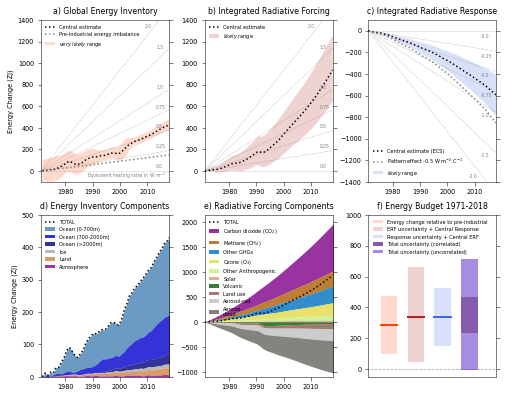

In [5]:
plt.figure(1)
f = plt.gcf()
# Set dimensions to 18 x 14 cm.. = 7.086 x 4.724 inces
f.set_size_inches(7.086, 5.512)
matplotlib.rcParams['font.size']=6.5
matplotlib.rcParams['axes.linewidth']=0.5 # set the value globally

#=========================================================
# Panel A = total Earth system warming with uncertainties
#=========================================================
WtoZJ = (5.1e14 * 31557600) / 1e21

e_yrs = energy_dict['yrs']
e_total = energy_dict['Total']
e_error = energy_dict['Total_error'] 

pi_total = (e_yrs - e_yrs[0]) * 0.2 * WtoZJ # convert 0.2 W m^-2 energy imbalance to Zetta Joules timeseries 

ax1 = plt.subplot(2, 3, 1)
plot_heating_rates()

ax1.fill_between(e_yrs, e_total-e_error*NINETY_TO_ONESIGMA, e_total+e_error*NINETY_TO_ONESIGMA, 
                 alpha=alpha, facecolor='orangered', label='$\it{very}$ $\it{likely}$ range')
ax1.plot(e_yrs, e_total, 'k', linewidth=LW, linestyle=':', label='Central estimate')
ax1.plot(e_yrs, pi_total, color='grey', linewidth=LW, linestyle=':', label='Pre-industrial energy imbalance')
ax1.text(1988, -60, 'Equivalent heating rates in W m$^{-2}$', fontsize=4.5, color='grey')
ax1.legend(loc='upper left', frameon=False, fontsize=5)
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
ax1.yaxis.set_ticks_position('both')
ax1.tick_params(width=0.5)
plt.ylabel('Energy Change (ZJ)')
plt.title('a) Global Energy Inventory')


#===========================================
# Panel B = Effective Radiative Forcing.. 
#===========================================

ax2 = plt.subplot(2, 3, 2)
plot_heating_rates()
plt.fill_between(ERF_dict['yrs'], ERF_dict['p17'], ERF_dict['p83'], 
                 alpha=alpha, facecolor='firebrick', label='$\it{likely}$ range')
plt.plot(ERF_dict['yrs'], ERF_dict['best'], color='k', linewidth=LW, linestyle=':', 
         label='Central estimate')
#plt.text(1984, -60, 'Equivalent heating rates in Wm$^{-2}$', fontsize=7.5, color='grey')
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
ax2.yaxis.set_ticks_position('both')
ax2.tick_params(width=0.5)
plt.title('b) Integrated Radiative Forcing')
plt.legend(loc='upper left', frameon=False, fontsize=5)

#=======================================
# Panel C = Radiative Response 
#=======================================

ax3 = plt.subplot(2, 3, 3)
plot_heating_rates(invert=True)
plt.fill_between(Resp_dict['yrs'], Resp_dict['p17'], Resp_dict['p83'], 
                 alpha=alpha, facecolor='royalblue', label='$\it{likely}$ range')
plt.plot(Resp_dict['yrs'], Resp_dict['p50'], color='k', linewidth=LW, linestyle=':', 
         label='Central estimate (ECS)')
plt.plot(Resp_dict['yrs'], Resp_dict['p50_0.5_pattern'], color='grey', linewidth=LW, linestyle=':', 
         label='Pattern effect -0.5 W m$^{-2}$ C$^{-1}$')
plt.xlim(xmin, xmax)
plt.ylim(-ymax, -ymin)
ax3.yaxis.set_ticks_position('both')
ax3.tick_params(width=0.5)
plt.title('c) Integrated Radiative Response')
plt.legend(loc='lower left', frameon=False, fontsize=5)


#============================================
# Panel D = Observed Energy Storage Change..
#============================================
e_comps = ['atmosphere', 'land', 'cryosphere', 
           'ocean_>2000m', 'ocean_700-2000m', 'ocean_0-700m']

ax4 = plt.subplot(2, 3, 4)

# Plot from total "downwards" for better legend/plot consistency
series = energy_dict['Total']
e_comps.reverse()

for cc, comp in enumerate(e_comps):
    label = label_dict[comp]
    newseries = series - energy_dict[comp]
    plt.fill_between(e_yrs, series, newseries, color=color_dict[comp], label=label, linewidth=0.0, alpha=0.8)
    series = newseries

plt.plot(e_yrs, e_total, 'k', linewidth=LW, linestyle=':', label='TOTAL')
ax4.legend(loc='upper left', frameon=False, fontsize=5)
plt.xlim(xmin, xmax)
plt.ylim(0, hcmax)
ax4.yaxis.set_ticks_position('both')
ax4.tick_params(width=0.5)
plt.ylabel('Energy Change (ZJ)')
plt.title('d) Energy Inventory Components')

#=============================================
# Panel E = Components of Radiative Forcing
#=============================================

# Color specification from Chris Smith / Johannes Quaas
colors = {'co2': '#7f0089',
          'ch4': '#ad5e00',
          'n2o': '#008e83',
          'ghg': '#0070c0',
          'o3': '#66665f',
          'aerosols': '#e5da47',
          'other_anth': '#c0f080',
          'anthro' : '#000000',
          'volcanic': '#006000',
          'solar': '#d0a070'}


ax5 = plt.subplot(2, 3, 5)
ERF_dictJ = read_ERF_2_Joules()
Jyrs = ERF_dictJ['yrs']
ERF_dictJ['otherAnth'] = ERF_dictJ['h2o_stratospheric'] + ERF_dictJ['contrails'] + ERF_dictJ['bc_on_snow']
ERF_dictJ['otherGHG'] =  ERF_dictJ['n2o'] + ERF_dictJ['other_wmghg']
ERF_dictJ['ozone'] = ERF_dictJ['o3']
ERF_pos = ['solar', 'otherAnth', 'ozone', 'otherGHG', 'ch4', 'co2']
ERF_neg = ['volcanic', 'land_use', 'aerosol-radiation_interactions', 
           'aerosol-cloud_interactions']
ERF_pos.reverse()

# Compute total positive ERFs
Tpos = + ERF_dictJ['solar'] + ERF_dictJ['ozone'] + ERF_dictJ['otherAnth'] + ERF_dictJ['otherGHG'] + ERF_dictJ['ch4'] + ERF_dictJ['co2']


series = Tpos
for cc, comp in enumerate(ERF_pos):
    label = label_dict[comp]
    color = color_dict[comp]
    newseries = series - ERF_dictJ[comp]
    plt.fill_between(Jyrs, series, newseries, label=label, linewidth=0.0, color=color, alpha=0.8)
    series = newseries

series = np.zeros(len(Jyrs)) # Initialise empty time series for plotting
for cc, comp in enumerate(ERF_neg):
    label = label_dict[comp]
    color = color_dict[comp]
    newseries = series + ERF_dictJ[comp]
    plt.fill_between(Jyrs, series, newseries, label=label, linewidth=0.0, color=color, alpha=0.8)
    series = newseries

    
# plt.plot(Jyrs, ERF_dictJ['total'], 'k', linewidth=LW, linestyle=':', label='TOTAL') # Cross-check: gives same result
plt.plot(ERF_dict['yrs'], ERF_dict['best'], 'k', linewidth=LW, linestyle=':', label='TOTAL')
plt.legend(loc='upper left', ncol=1, frameon=False, fontsize=5)
plt.xlim(xmin, xmax)
plt.ylim(-1100, 2150)
ax5.axhline(0, ls=':', lw=0.5, color='k')
ax5.yaxis.set_ticks_position('both')
ax5.tick_params(width=0.5)
plt.title('e) Radiative Forcing Components')

#=======================================================================
# Panel F = Energy Budget for period 1971-2015 (1971-2018 placeholder)
#=======================================================================
ax6 = plt.subplot(2, 3, 6)

names = ['Energy change relative to pre-industrial',
         'ERF uncertainty + Central Response',
         'Response uncertainty + Central ERF'] 

mid, low_c, upp_c = budget_dict['Total uncertainty (correlated)']
mid, low_uc, upp_uc = budget_dict['Total uncertainty (uncorrelated)']

for nn, name in enumerate(names):
    xpts = [nn-0.3, nn+0.3]
    mid, low, upp = budget_dict[name]
    color = color_dict[name]
    plt.fill_between(xpts, low, upp, facecolor=color, alpha=alpha, 
                 label=name)
    plt.plot(xpts, [mid, mid], linewidth=2.0, color=color)

nn += 1
xpts = [nn-0.3, nn+0.3]
plt.fill_between(xpts, low_c, upp_c, facecolor='rebeccapurple', alpha=0.8, 
                 label='Total uncertainty (correlated)')
plt.fill_between(xpts, upp_c, upp_uc, facecolor='mediumpurple', alpha=0.8, 
                 label='Total uncertainty (uncorrelated)')
plt.fill_between(xpts, low_c, low_uc, facecolor='mediumpurple', alpha=0.8)
 
plt.legend(loc='upper left', frameon=False, fontsize=5)
plt.xlim(-0.75, 4.0)
plt.title('f) Energy Budget 1971-2018')
plt.ylim(hcmin*2, hcmax*2)
ax6.axhline(0, ls=':', lw=0.5, color='k')
ax6.yaxis.set_ticks_position('both')
ax6.tick_params(width=0.5)
ax6.set_xticks([-100.])


plt.tight_layout(w_pad=0.1)
print("Saving file: ", plotdir+plotfile1)
print("Saving file: ", plotdir+plotfile2)
plt.savefig(plotdir+plotfile1,dpi=300,format='png')
plt.savefig(plotdir+plotfile2,dpi=300,format='pdf')